# 词汇的星空——词向量（Word Vector）技术

在这节课中，我们学习了如何通过人工神经网络得到单词的向量表达。

首先，我们构建了一个简单的NGram语言模型，根据N个历史词汇预测下一个单词，从而得到每一个单词的向量表示。我们用小说《三体》为例，展示了我们的词向量嵌入效果。

其次，我们学习了如何使用成熟的Google开发的Word2Vec包来进行大规模语料的词向量训练，以及如何加载已经训练好的词向量，从而利用这些词向量来做一些简单的运算和测试。

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [3]:
# 加载必要的程序包
# PyTorch的程序包
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 数值运算和绘图的程序包
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# 加载机器学习的软件包
from sklearn.decomposition import PCA

#加载Word2Vec的软件包
import gensim as gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.word2vec import LineSentence

#加载‘结巴’中文分词软件包

import jieba

#加载正则表达式处理的包
import re

%matplotlib inline

## 一、NGram 词向量模型

NGram词向量模型的原理是利用一个人工神经网络来根据前N个单词来预测下一个单词，从而得到每个单词的词向量

### 1. 文本预处理

我们以刘慈欣著名的科幻小说《三体》为例，来展示利用NGram模型训练词向量的方法

预处理分为两个步骤：

1、读取文件

2、分词

3、将语料划分为N＋1元组，准备好训练用数据

在这里，我们并没有去除标点符号，一是为了编程简洁，而是考虑到分词会自动将标点符号当作一个单词处理，因此不需要额外考虑。

#### 1). 读入原始文件，晒掉所有标点符号

In [4]:
#读入原始文件

f = open("3body.txt", 'r')
# 若想加快运行速度，使用下面的语句（选用了三体的其中一章）：
#f = open("3body.txt", 'r') 
text = str(f.read())
f.close()

text[0:100]

'疯狂年代\n\n中国，1967年。\n\n“红色联合”对“四?二八兵团”总部大楼的攻击已持续了两天，他们的旗帜在大楼周围躁动地飘扬着，仿佛渴望干柴的火种。“红色联合”的指挥官心急如焚，他并不惧怕大楼的守卫者，'

#### 2)、分词，并去掉标点符号

In [5]:
# 分词
temp = jieba.lcut(text)
words = []
for i in temp:
    #过滤掉所有的标点符号
    i = re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：]+", "", i)
    if len(i) > 0:
        words.append(i)
print(len(words))
words[0:10]

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.708 seconds.
Prefix dict has been built succesfully.


100803


['疯狂', '年代', '中国', '1967', '年', '“', '红色', '联合', '对', '“']

#### 3)、构建N+1元组，将单词进行编码

In [6]:
# 构建三元组列表.  每一个元素为： ([ i-2位置的词, i-1位置的词 ], 下一个词)
# 我们选择的Ngram中的N，即窗口大小为2
trigrams = [([words[i], words[i + 1]], words[i + 2]) for i in range(len(words) - 2)]
# 打印出前三个元素看看
print(trigrams[:3])

[(['疯狂', '年代'], '中国'), (['年代', '中国'], '1967'), (['中国', '1967'], '年')]


#### 4). 将每个单词进行编码，构造字典

In [7]:
# 得到词汇表
vocab = set(words)
print(len(vocab))
# 两个字典，一个根据单词索引其编号，一个根据编号索引单词
#word_to_idx中的值包含两部分，一部分为id，另一部分为单词出现的次数
#word_to_idx中的每一个元素形如：{w:[id, count]}，其中w为一个词，id为该词的编号，count为该单词在words全文中出现的次数
word_to_idx = {} 
idx_to_word = {}
ids = 0

#对全文循环，构件这两个字典
for w in words:
    cnt = word_to_idx.get(w, [ids, 0])
    if cnt[1] == 0:
        ids += 1
    cnt[1] += 1
    word_to_idx[w] = cnt
    idx_to_word[ids] = w

13879


### 2、构造模型并训练

#### 1). 构造NGram神经网络模型

我们构造了一个三层的网络：

1、输入层：embedding层，这一层的作用是：先将输入单词的编号映射为一个one hot编码的向量，形如：001000，维度为单词表大小。
然后，embedding会通过一个线性的神经网络层映射到这个词的向量表示，输出为embedding_dim

2、线性层，从embedding_dim维度到128维度，然后经过非线性ReLU函数

3、线性层：从128维度到单词表大小维度，然后log softmax函数，给出预测每个单词的概率

In [8]:
class NGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  #嵌入层
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) #线性层
        self.linear2 = nn.Linear(128, vocab_size) #线性层

    def forward(self, inputs):
        #嵌入运算，嵌入运算在内部分为两步：将输入的单词编码映射为one hot向量表示，然后经过一个线性层得到单词的词向量
        embeds = self.embeddings(inputs).view(1, -1)
        # 线性层加ReLU
        out = F.relu(self.linear1(embeds))
        
        # 线性层加Softmax
        out = self.linear2(out)
        log_probs = F.log_softmax(out)
        return log_probs
    def extract(self, inputs):
        embeds = self.embeddings(inputs)
        return embeds

#### 2). 开始训练模型

In [15]:
losses = [] #纪录每一步的损失函数
criterion = nn.NLLLoss() #运用负对数似然函数作为目标函数（常用于多分类问题的目标函数）
model = NGram(len(vocab), 10, 2).cuda() #定义NGram模型，向量嵌入维数为10维，N（窗口大小）为2
print(model)
optimizer = optim.SGD(model.parameters(), lr=0.001) #使用随机梯度下降算法作为优化器

#循环100个周期
for epoch in range(30):
    total_loss = torch.Tensor([0]).cuda()
    for context, target in trigrams:

        # 准备好输入模型的数据，将词汇映射为编码
        context_idxs = [word_to_idx[w][0] for w in context]
        
        # 包装成PyTorch的Variable
        context_var = Variable(torch.LongTensor(context_idxs)).cuda()

        # 清空梯度：注意PyTorch会在调用backward的时候自动积累梯度信息，故而每隔周期要清空梯度信息一次。
        optimizer.zero_grad()

        # 用神经网络做计算，计算得到输出的每个单词的可能概率对数值
        log_probs = model(context_var)

        # 计算损失函数，同样需要把目标数据转化为编码，并包装为Variable
        loss = criterion(log_probs, Variable(torch.LongTensor([word_to_idx[target][0]])).cuda())

        # 梯度反传
        loss.backward()
        
        # 对网络进行优化
        optimizer.step()
        
        # 累加损失函数值
        total_loss += loss.data
    losses.append(total_loss)
    print('第{}轮，损失函数为：{:.2f}'.format(epoch, total_loss.cpu().numpy()[0]))

NGram (
  (embeddings): Embedding(13879, 10)
  (linear1): Linear (20 -> 128)
  (linear2): Linear (128 -> 13879)
)
第0轮，损失函数为：816686.00
第1轮，损失函数为：749016.50
第2轮，损失函数为：733387.56
第3轮，损失函数为：724530.50
第4轮，损失函数为：717675.06
第5轮，损失函数为：711599.75
第6轮，损失函数为：705822.69
第7轮，损失函数为：700155.50
第8轮，损失函数为：694507.62
第9轮，损失函数为：688809.19
第10轮，损失函数为：683029.94
第11轮，损失函数为：677139.81
第12轮，损失函数为：671125.62
第13轮，损失函数为：664975.38
第14轮，损失函数为：658682.88
第15轮，损失函数为：652247.62
第16轮，损失函数为：645686.00
第17轮，损失函数为：639005.56
第18轮，损失函数为：632224.62
第19轮，损失函数为：625356.44
第20轮，损失函数为：618442.38
第21轮，损失函数为：611507.38
第22轮，损失函数为：604565.31
第23轮，损失函数为：597661.88
第24轮，损失函数为：590811.69
第25轮，损失函数为：584047.12
第26轮，损失函数为：577383.00
第27轮，损失函数为：570839.75
第28轮，损失函数为：564431.06
第29轮，损失函数为：558169.50


### 3. 结果展示
#### 1). 将向量投影到二维平面进行可视化

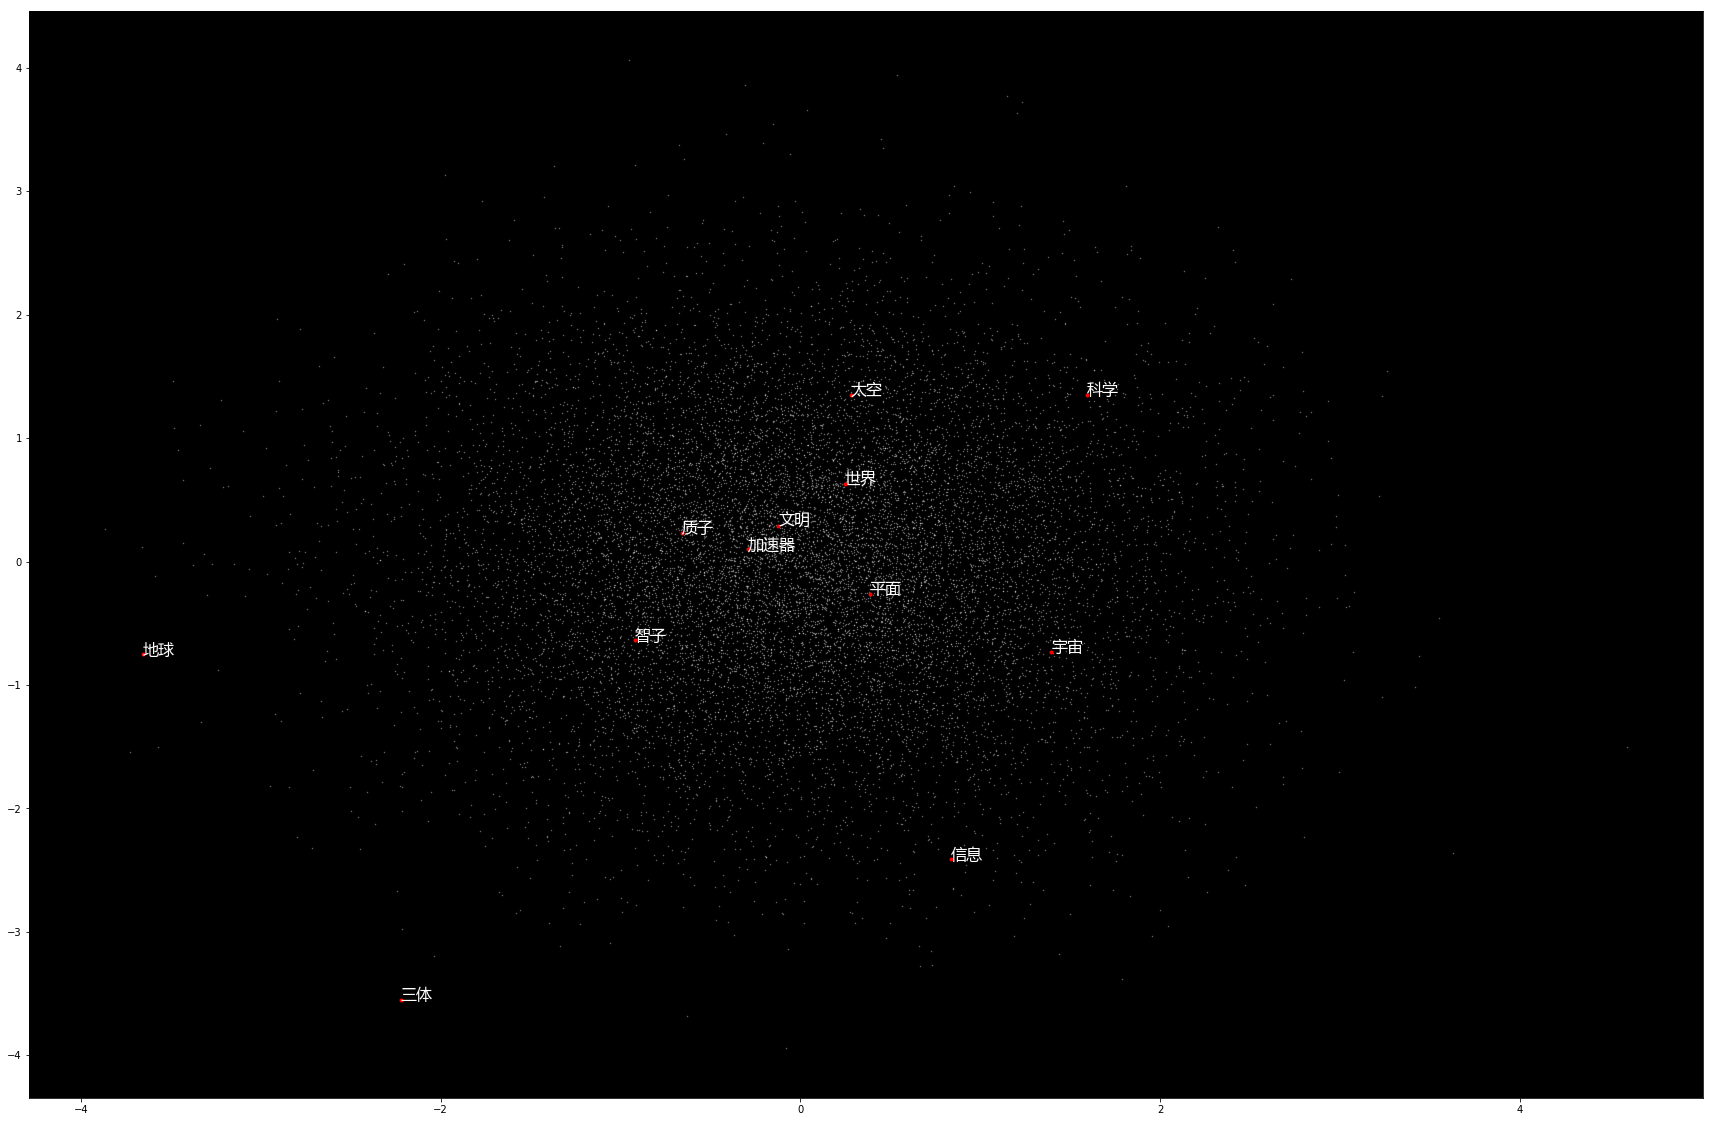

In [22]:
# 从训练好的模型中提取每个单词的向量
vec = model.extract(Variable(torch.LongTensor([v[0] for v in word_to_idx.values()]).cuda()))
vec = vec.cpu().data.numpy()

# 利用PCA算法进行降维
X_reduced = PCA(n_components=2).fit_transform(vec)


# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (30, 20))
ax = fig.gca()
ax.set_facecolor('black')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.4, color = 'white')


# 绘制几个特殊单词的向量
words = ['智子', '地球', '三体', '质子', '科学', '世界', '文明', '太空', '加速器', '平面', '宇宙', '信息']

# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='/home/fuyang/.fonts/YaHei.Consolas.1.11b.ttf', size=16)
for w in words:
    if w in word_to_idx:
        ind = word_to_idx[w][0]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'white') # 

#### 2). 临近词向量

In [23]:
# 定义计算cosine相似度的函数
def cos_similarity(vec1, vec2):
    
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    norm = norm1 * norm2
    dot = np.dot(vec1, vec2)
    result = dot / norm if norm > 0 else 0
    return result
    
# 在所有的词向量中寻找到与目标词（word）相近的向量，并按相似度进行排列
def find_most_similar(word, vectors, word_idx):
    vector = vectors[word_to_idx[word][0]]
    simi = [[cos_similarity(vector, vectors[num]), key] for num, key in enumerate(word_idx.keys())]
    sort = sorted(simi)[::-1]
    words = [i[1] for i in sort]
    return words

# 与智子靠近的词汇
find_most_similar('智子', vec, word_to_idx)[0:10]

['智子', '封存', '以群', '接听', '举行', '相似', '各得', '脑海中', '身旁', '会害']

In [27]:
find_most_similar('风景', vec, word_to_idx)[0:10]

['风景', '发', '面临', '等离子', '不经意', '这种', '训练', '天真', '重大', '选择']

## 二、Word2Vec

Word2Vec是Google推出的一个开源的词向量计算工具，它被内嵌到了gensim软件包里。
在本课程中，我们主要展示了自己调用Word2Vec训练词向量和读取已经训练好的词向量两种方法，并展示了如何利用词向量来进行一些简单的推理

### 1. 自己训练一个小语料

In [28]:
# 读入文件、分词，形成一句一句的语料
# 注意跟前面处理不一样的地方在于，我们一行一行地读入文件，从而自然利用行将文章分开成“句子”
f = open("3body.txt", 'r')
lines = []
for line in f:
    temp = jieba.lcut(line)
    words = []
    for i in temp:
        #过滤掉所有的标点符号
        i = re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", i)
        if len(i) > 0:
            words.append(i)
    if len(words) > 0:
        lines.append(words)
    

In [29]:
# 调用Word2Vec的算法进行训练。
# 参数分别为：size: 嵌入后的词向量维度；window: 上下文的宽度，min_count为考虑计算的单词的最低词频阈值
model = Word2Vec(lines, size = 20, window = 2 , min_count = 0)

In [30]:
model.wv.most_similar('三体', topn = 20)

[('红岸', 0.9993405342102051),
 ('计算机', 0.9991818070411682),
 ('杨冬', 0.999061644077301),
 ('地球', 0.9990451335906982),
 ('这个', 0.9987905025482178),
 ('技术', 0.9987446665763855),
 ('信息', 0.9987429976463318),
 ('这是', 0.9987272024154663),
 ('镜面', 0.9987210035324097),
 ('又', 0.9986690282821655),
 ('基础', 0.998660683631897),
 ('开始', 0.9986225366592407),
 ('发射', 0.9986110329627991),
 ('在', 0.9986000061035156),
 ('能够', 0.998595118522644),
 ('人类', 0.9985946416854858),
 ('成为', 0.9985858201980591),
 ('那个', 0.9985843300819397),
 ('巨大', 0.9985759854316711),
 ('却', 0.9985712766647339)]

In [31]:
# 将词向量投影到二维空间
rawWordVec = []
word2ind = {}
for i, w in enumerate(model.wv.vocab):
    rawWordVec.append(model[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

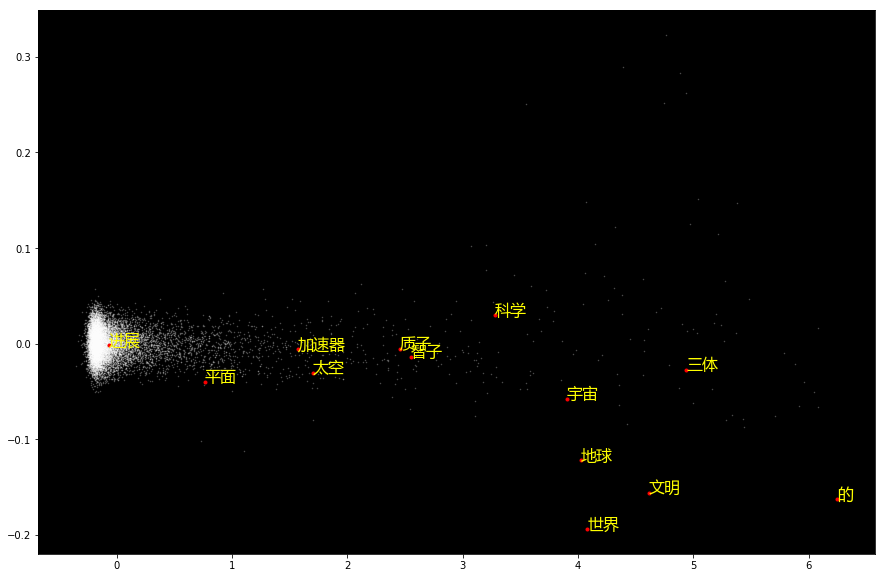

In [32]:
# 绘制星空图
# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
ax.set_facecolor('black')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.3, color = 'white')


# 绘制几个特殊单词的向量
words = ['智子', '地球', '三体', '质子', '科学', '世界', '文明', '太空', '加速器', '平面', '宇宙', '进展','的']

# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname='/home/fuyang/.fonts/YaHei.Consolas.1.11b.ttf', size=16)
for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'yellow')

### 2、调用一个现成的词向量

1). 大规模词向量可视化

该中文词向量库是由尹相志提供，训练语料来源为：微博、人民日报、上海热线、汽车之家等，包含1366130个词向量，
下载地址为：链接：http://pan.baidu.com/s/1gePQAun 密码：kvtg

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第VI课的配套源代码

In [33]:
# 加载词向量
word_vectors = KeyedVectors.load_word2vec_format('vectors.bin', binary=True, unicode_errors='ignore')
len(word_vectors.vocab)

1366130

In [34]:
# PCA降维
rawWordVec = []
word2ind = {}
for i, w in enumerate(word_vectors.vocab):
    rawWordVec.append(word_vectors[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

In [35]:
# 查看相似词
word_vectors.most_similar('物理', topn = 20)

[('化学', 0.7124662399291992),
 ('物理化学', 0.6906830072402954),
 ('物理学', 0.6732755303382874),
 ('力学', 0.6633583307266235),
 ('数学', 0.6431227326393127),
 ('电学', 0.6256974935531616),
 ('原理', 0.6226458549499512),
 ('生物学', 0.6126975417137146),
 ('数学物理', 0.6115936040878296),
 ('电化学', 0.6058178544044495),
 ('非线性', 0.595616340637207),
 ('量子力学', 0.5924554467201233),
 ('热学', 0.5853999853134155),
 ('电磁场', 0.5820313096046448),
 ('物理现象', 0.5818398594856262),
 ('凝聚态', 0.5746456384658813),
 ('计算机', 0.5690045356750488),
 ('流体力学', 0.5671141147613525),
 ('化学性', 0.563992440700531),
 ('微积分', 0.5628953576087952)]

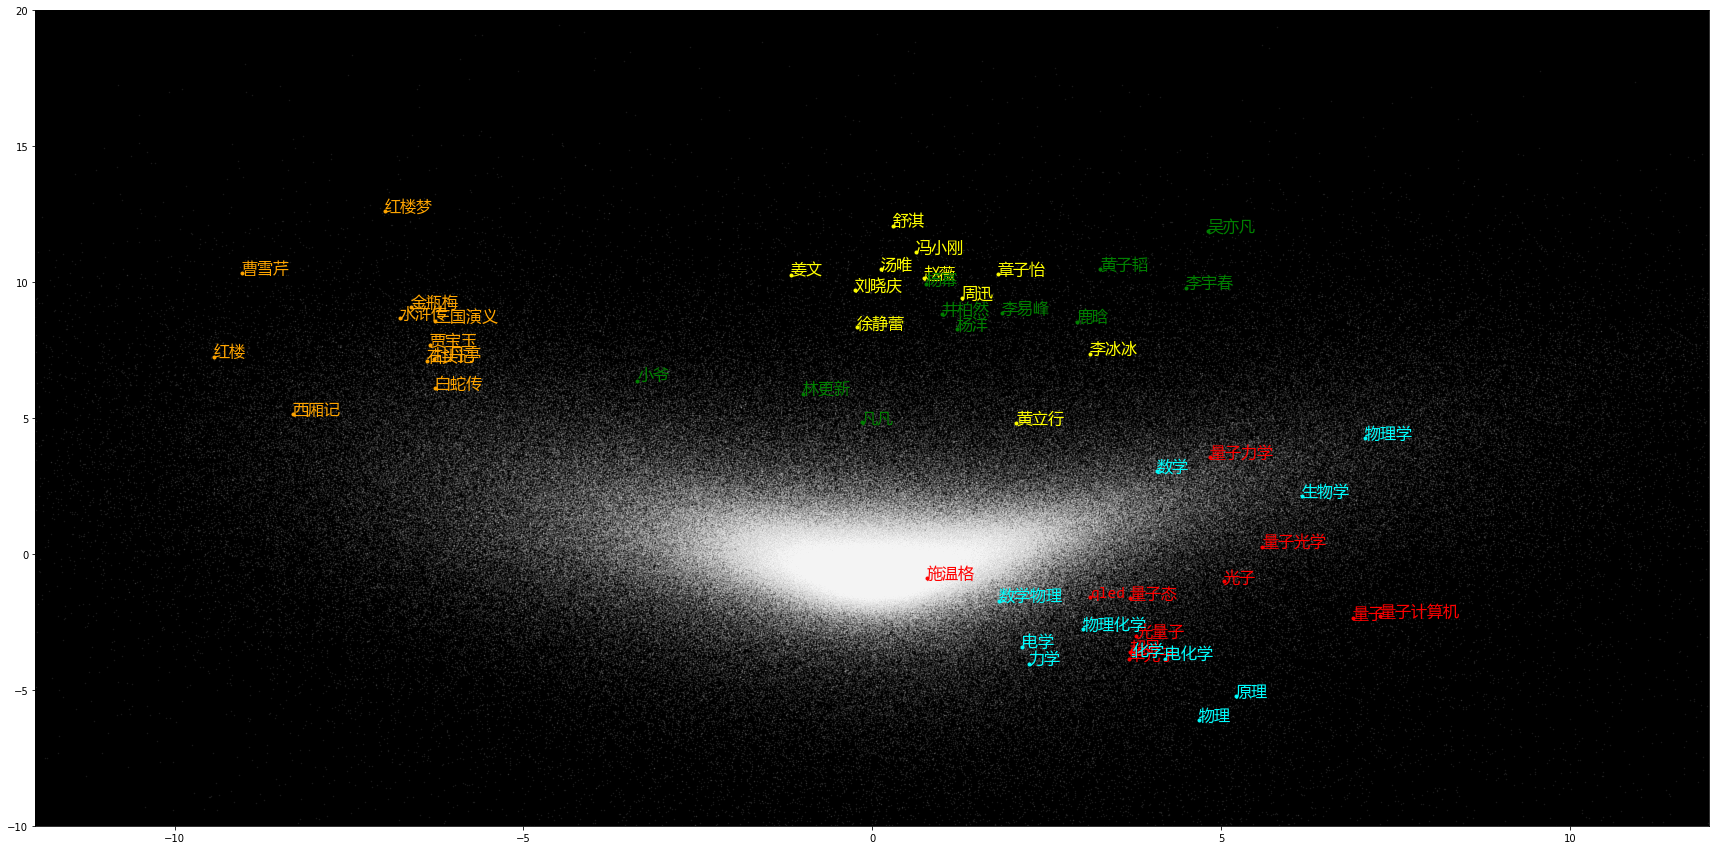

In [36]:
# 绘制星空图
# 绘制所有的词汇
fig = plt.figure(figsize = (30, 15))
ax = fig.gca()
ax.set_facecolor('black')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.1, color = 'white')

ax.set_xlim([-12,12])
ax.set_ylim([-10,20])


# 选择几个特殊词汇，不仅画它们的位置，而且把它们的临近词也画出来
words = {'徐静蕾','吴亦凡','物理','红楼梦','量子'}
all_words = []
for w in words:
    lst = word_vectors.most_similar(w)
    wds = [i[0] for i in lst]
    metrics = [i[1] for i in lst]
    wds = np.append(wds, w)
    all_words.append(wds)


zhfont1 = matplotlib.font_manager.FontProperties(fname='/home/fuyang/.fonts/YaHei.Consolas.1.11b.ttf', size=16)
colors = ['red', 'yellow', 'orange', 'green', 'cyan', 'cyan']
for num, wds in enumerate(all_words):
    for w in wds:
        if w in word2ind:
            ind = word2ind[w]
            xy = X_reduced[ind]
            plt.plot(xy[0], xy[1], '.', alpha =1, color = colors[num])
            plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = colors[num])

#### 2). 类比关系实验

In [37]:
# 女人－男人＝？－国王
words = word_vectors.most_similar(positive=['女人', '国王'], negative=['男人'])
words

[('王后', 0.6745086312294006),
 ('国王队', 0.6190646886825562),
 ('爵士', 0.6134730577468872),
 ('路易十四', 0.6120332479476929),
 ('萨克拉门托', 0.6105179786682129),
 ('莱恩', 0.609720766544342),
 ('教皇', 0.6067279577255249),
 ('乔治', 0.6061576008796692),
 ('拿破仑', 0.596650242805481),
 ('路易十五', 0.5955969095230103)]

In [38]:
# 北京－中国＝？－俄罗斯
words = word_vectors.most_similar(positive=['北京', '俄罗斯'], negative=['中国'])
words

[('莫斯科', 0.6559879779815674),
 ('明斯克', 0.5312925577163696),
 ('基辅', 0.5114986896514893),
 ('伊尔库茨克', 0.510644793510437),
 ('安卡拉', 0.503899872303009),
 ('哈萨克斯坦', 0.5037742257118225),
 ('白俄罗斯', 0.49618425965309143),
 ('新西伯利亚', 0.49343931674957275),
 ('圣彼得堡', 0.49158066511154175),
 ('加里宁格勒', 0.48882216215133667)]

In [39]:
# 自然科学－物理学＝？－政治学
words = word_vectors.most_similar(positive=['自然科学', '政治学'], negative=['物理学'])
words

[('人文科学', 0.6870070099830627),
 ('社科', 0.6561877727508545),
 ('历史学', 0.6510788202285767),
 ('社会学', 0.6255476474761963),
 ('法学', 0.6240648031234741),
 ('人文学科', 0.6205806136131287),
 ('外交学', 0.6159368753433228),
 ('社会科学', 0.6153010725975037),
 ('人类学', 0.6027011871337891),
 ('社科类', 0.6017463207244873)]

In [40]:
# 王菲－章子怡＝？－汪峰
words = word_vectors.most_similar(positive=['王菲', '汪峰'], negative=['章子怡'])
words

[('窦唯', 0.7128487825393677),
 ('窦靖童', 0.6921027302742004),
 ('张韶涵', 0.6702383160591125),
 ('齐秦', 0.6421184539794922),
 ('谢霆锋', 0.6239088177680969),
 ('那英', 0.6225878596305847),
 ('哈林', 0.6223201751708984),
 ('李亚鹏', 0.6200002431869507),
 ('张惠妹', 0.615531325340271),
 ('李宗盛', 0.6131705045700073)]

In [41]:
# 尽可能多地选出所有的货币
words = word_vectors.most_similar(positive=['美元', '英镑'], topn = 100)
#words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], topn = 100)
#words = word_vectors.most_similar(positive=['美元', '英镑', '日元'], negative = ['原油价格', '7800万'], topn = 100)
words[0:20]

[('欧元', 0.8951539397239685),
 ('日元', 0.8059478998184204),
 ('澳元', 0.7766220569610596),
 ('美金', 0.745575487613678),
 ('镑', 0.7270613312721252),
 ('人民币', 0.7206563949584961),
 ('加元', 0.7068080902099609),
 ('英磅', 0.6899423003196716),
 ('韩元', 0.6676418781280518),
 ('日圆', 0.6659780740737915),
 ('卢布', 0.6631942987442017),
 ('港元', 0.6606216430664062),
 ('瑞郎', 0.6473335027694702),
 ('卢比', 0.6468612551689148),
 ('比索', 0.6323482990264893),
 ('雷亚尔', 0.620173454284668),
 ('美圆', 0.5887085795402527),
 ('挪威克朗', 0.588290810585022),
 ('丹麦克朗', 0.5871578454971313),
 ('马币', 0.572658360004425)]

本文件是集智AI学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码